In [ ]:
#!/bin/bash
# https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data
!kaggle datasets download sartajbhuvaji/brain-tumor-classification-mri
!unzip "./brain-tumor-classification-mri.zip"


In [19]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import pandas as pd
from aux import ImagesMRIDataset, split_for_cross_validation, get_training_testing_data, plot_data, get_data_distribution, split_traing_data

class EarlyStopping():
    def __init__(self, path : str, patience=5, threshold=1e-4):
        self.patience = patience
        self.threshold = threshold
        self.min_loss = 10000
        self.steps_till_stop = 0
        self.path = path

    def continue_training(self, model, loss):
        if(loss < self.min_loss - self.threshold):
            self.min_loss = loss
            self.steps_till_stop = 0
            torch.save(model.state_dict(), self.path)
            return True
        if (loss >= self.min_loss - self.threshold):
            self.steps_till_stop += 1
            if (self.steps_till_stop == self.patience): return False
        return True
    
    def load_model(self, model):
        model.load_state_dict(torch.load(self.path, weights_only=True))
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        return model


In [82]:
SIZE = (125, 125)
train_transform = A.Compose([
    A.Resize(height=SIZE[0], width=SIZE[1]),  
    A.RandomGamma(gamma_limit=(80, 120), p=1.0), 
    A.HorizontalFlip(p = 0.5),
    A.ShiftScaleRotate(p = 0.5),
    A.CLAHE(clip_limit=5.0, tile_grid_size=(8, 8), p=1.0), 
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8), 
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

test_transformations = A.Compose([
    A.Resize(height=SIZE[0], width=SIZE[1]),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

def compute_train_transformations(image):
    image = train_transform(image=image)["image"]
    return np.array(image.transpose((2, 0, 1)), dtype=np.float32)
    
def compute_test_transformation(image):
    image = test_transformations(image=image)["image"]
    return np.array(image.transpose((2, 0, 1)), dtype=np.float32)


/home/alf/anul4/InvatareSupervizataTema2/venv/lib/python3.12/site-packages/albumentations/core/validation.py:45: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [83]:
def training_loop(model, criterion, optimizer, dataloader : DataLoader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  current_training_loss = 0
  all_train_labels, all_train_preds = [], []
  model.train()
  for idx, (images, labels) in enumerate(dataloader):
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    output = output.to(device)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    current_training_loss += loss.item()
    all_train_preds.extend(output.argmax(dim=1).cpu().numpy())
    all_train_labels.extend(labels.cpu().numpy())
  return 2 * current_training_loss / len(dataloader),  all_train_preds, all_train_labels


def validation_loop(model, criterion, dataloader : DataLoader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_val_labels, all_val_preds = [], [],
    current_validation_loss = 0
    model.eval()
    with torch.no_grad():
      for idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        output = output.to(device)
        loss = criterion(output, labels)
        current_validation_loss += loss.item()
        all_val_labels.extend(labels.cpu().numpy())
        all_val_preds.extend(output.argmax(dim=1).cpu().numpy())
    return 2 * current_validation_loss / len(dataloader),  all_val_preds, all_val_labels

def train_model(model, epochs, data, criterion, optimizer, lr_scheduler, early_stopping : EarlyStopping):
  training_loss = [] 
  validation_loss = []
  training_accuracy = []
  validation_accuracy = []
  maxim_accuracy = -1
  for i in range(epochs):
      Tloss, train_pred, train_labels = training_loop(model, criterion, optimizer, data["train"])
      Vloss, all_val_preds, all_val_labels = validation_loop(model, criterion, data["validation"])
      if (not early_stopping.continue_training(model, Vloss)):
         print("Loss-ul nu a scazut de ceva vreme, a intervenit early stopping")
         break
      lr_scheduler.step(Vloss)
      training_loss.append(round(Tloss, 3))
      validation_loss.append(round(Vloss, 3))
      training_accuracy.append(round(accuracy_score(train_pred, train_labels), 3))
      validation_accuracy.append(round(accuracy_score(all_val_labels, all_val_preds), 3))
      if (maxim_accuracy < validation_accuracy[-1]):
        print(f"best model found at {i}", f"loss is {validation_loss[-1]}", f"accuracy is {validation_accuracy[-1]}")
        maxim_accuracy = validation_accuracy[-1]
      else:
         print(f"epoca {i}", f"loss is {validation_loss[-1]}", f"accuracy is {validation_accuracy[-1]}")
  return training_loss, validation_loss, training_accuracy, validation_accuracy

def test_model(model, dataloader, criterion):
    _, preds, labels = validation_loop(model, criterion, dataloader)
    precision = precision_score(preds, labels, average='macro') 
    recall = recall_score(preds, labels, average='macro')
    f1 = f1_score(preds, labels, average='macro')
    acc = accuracy_score(preds, labels)
    return precision, recall, f1, acc, confusion_matrix(preds, labels)


In [84]:
class Net(nn.Module):
    def __init__(self,  width : int, expansion : int):
        super().__init__()
        self.relu = nn.ReLU()
        self.width1 = width
        self.conv1 = nn.Conv2d(3, self.width1, kernel_size=(3, 3))
        self.bn1 = nn.BatchNorm2d(self.width1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width2 = self.width1 * expansion
        self.conv2 = nn.Conv2d(self.width1, self.width2, kernel_size=(3, 3))
        self.bn2 = nn.BatchNorm2d(self.width2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width3 = self.width2 * expansion
        self.conv3 = nn.Conv2d(self.width2, self.width3, kernel_size=(5, 5))
        self.bn3 = nn.BatchNorm2d(self.width3)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width4 = self.width3 * expansion
        self.conv4 = nn.Conv2d(self.width3, self.width4, kernel_size=(3, 3))
        self.bn4 = nn.BatchNorm2d(self.width4)
        self.maxpool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width5 = self.width4 * expansion
        self.conv5 = nn.Conv2d(self.width4, self.width5, kernel_size=(3, 3))
        self.bn5 = nn.BatchNorm2d(self.width5)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classification_layer = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(self.width5, self.width4),
            nn.Dropout(p=0.5),
            nn.Linear(self.width4, self.width3),
            nn.Dropout(p=0.5),
            nn.Linear(self.width3, 4),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, x : torch.tensor):
        x = self.maxpool1(self.relu(self.bn1(self.conv1(x))))
        x = self.maxpool2(self.relu(self.bn2(self.conv2(x))))
        x = self.maxpool3(self.relu(self.bn3(self.conv3(x))))
        x = self.maxpool4(self.relu(self.bn4(self.conv4(x))))
        x = self.avgpool(self.relu(self.bn5(self.conv5(x))))
        return self.classification_layer(x)

model_try = Net(width=8, expansion=3)

for module in model_try.modules():
    param_count = sum(p.numel() for p in module.parameters() if p.requires_grad)
    print(f"Layer Type: {module}, Number of Parameters: {param_count}")

Layer Type: Net(
  (relu): ReLU()
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 24, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(24, 72, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(72, 216, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(216, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode

In [85]:
def show_plot(list1, list2, label1, label2, title):
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(1, len(list1) + 1), y=list1, label=label1, marker='o')
    sns.lineplot(x=range(1, len(list2) + 1), y=list2, label=label2, marker='o')
    plt.xlabel(label1)   
    plt.ylabel(label2)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def save_matrix(matrix):
    cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [0, 1, 2, 3])
    cm_display.plot()
    plt.tight_layout()
    plt.show()
    
def add_info(info_data, precision, acc, recall, f1):
    info_data["precision"].append(precision)
    info_data["accuracy"].append(acc)
    info_data["recall"].append(recall)
    info_data["f1Score"].append(f1)
    return info_data


def create_cross_validation_data(data_chunks, test_data, current : int, train_transform, test_transform, batch_size):
    training_data = []
    for idx, chunk in enumerate(data_chunks):
        if (idx == current):
            continue
        training_data += chunk
    return {
        "train": DataLoader(ImagesMRIDataset(training_data, transformations=train_transform), batch_size=batch_size, shuffle=True, drop_last=True),
        "validation": DataLoader(ImagesMRIDataset(data_chunks[current], transformations=test_transform), batch_size=batch_size, shuffle=True),
        "test": DataLoader(ImagesMRIDataset(test_data, transformations=test_transform), batch_size=batch_size, shuffle=True)
    }

best model found at 0 loss is 3.399 accuracy is 0.358
best model found at 1 loss is 2.483 accuracy is 0.502
best model found at 2 loss is 2.147 accuracy is 0.585
epoca 3 loss is 2.742 accuracy is 0.545
best model found at 4 loss is 1.567 accuracy is 0.67
epoca 5 loss is 2.604 accuracy is 0.589
epoca 6 loss is 1.629 accuracy is 0.653
best model found at 7 loss is 0.989 accuracy is 0.819
epoca 8 loss is 1.153 accuracy is 0.775
epoca 9 loss is 2.937 accuracy is 0.574
epoca 10 loss is 1.615 accuracy is 0.706
epoca 11 loss is 1.087 accuracy is 0.798
epoca 12 loss is 1.228 accuracy is 0.757
best model found at 13 loss is 0.699 accuracy is 0.868
epoca 14 loss is 1.405 accuracy is 0.74
epoca 15 loss is 1.539 accuracy is 0.749
epoca 16 loss is 1.131 accuracy is 0.792
epoca 17 loss is 0.936 accuracy is 0.845
epoca 18 loss is 0.807 accuracy is 0.851
best model found at 19 loss is 0.644 accuracy is 0.894
epoca 20 loss is 0.748 accuracy is 0.866
best model found at 21 loss is 0.503 accuracy is 0.93

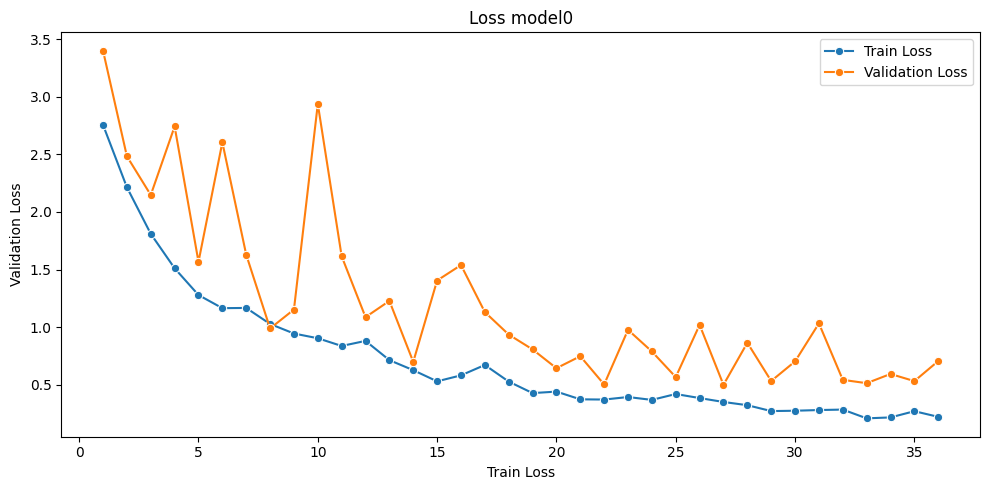

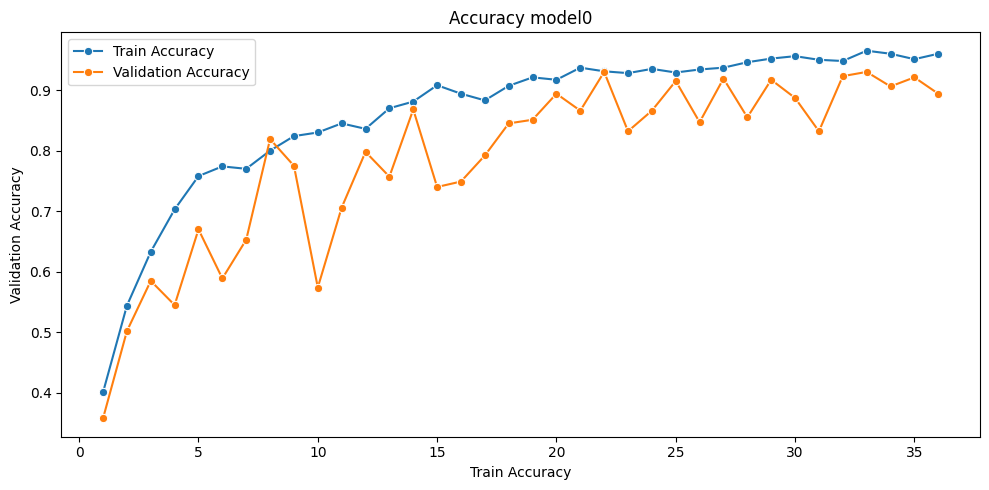

best model found at 0 loss is 3.294 accuracy is 0.407
best model found at 1 loss is 3.275 accuracy is 0.413
best model found at 2 loss is 2.201 accuracy is 0.538
best model found at 3 loss is 2.072 accuracy is 0.616
best model found at 4 loss is 1.768 accuracy is 0.633
epoca 5 loss is 2.585 accuracy is 0.544
best model found at 6 loss is 1.929 accuracy is 0.642
best model found at 7 loss is 1.068 accuracy is 0.794
best model found at 8 loss is 0.868 accuracy is 0.852
epoca 9 loss is 1.002 accuracy is 0.812
epoca 10 loss is 2.565 accuracy is 0.536
epoca 11 loss is 0.877 accuracy is 0.848
epoca 12 loss is 1.677 accuracy is 0.68
epoca 13 loss is 0.828 accuracy is 0.837
epoca 14 loss is 1.538 accuracy is 0.712
best model found at 15 loss is 0.768 accuracy is 0.871
epoca 16 loss is 0.953 accuracy is 0.816
epoca 17 loss is 0.94 accuracy is 0.822
epoca 18 loss is 0.733 accuracy is 0.871
best model found at 19 loss is 0.544 accuracy is 0.915
epoca 20 loss is 0.593 accuracy is 0.883
epoca 21 lo

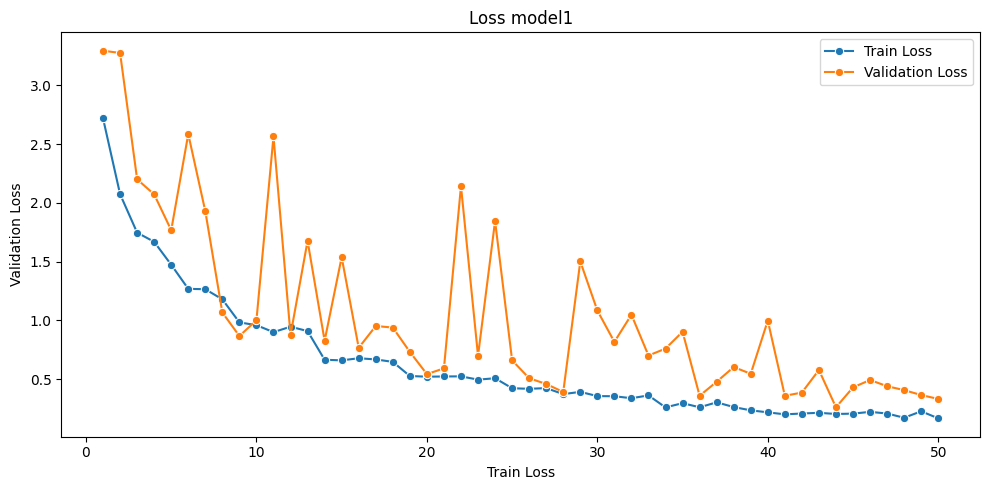

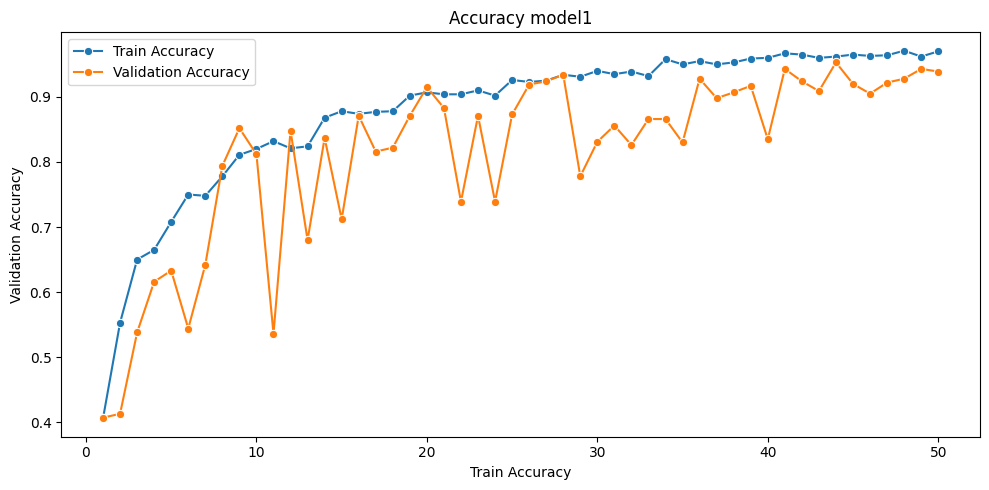

best model found at 0 loss is 2.26 accuracy is 0.463
epoca 1 loss is 2.787 accuracy is 0.393
best model found at 2 loss is 1.576 accuracy is 0.742
epoca 3 loss is 2.402 accuracy is 0.51
epoca 4 loss is 1.607 accuracy is 0.674
epoca 5 loss is 2.921 accuracy is 0.552
epoca 6 loss is 2.525 accuracy is 0.546
epoca 7 loss is 2.162 accuracy is 0.584
best model found at 8 loss is 0.966 accuracy is 0.789
epoca 9 loss is 1.116 accuracy is 0.755
epoca 10 loss is 1.258 accuracy is 0.767
best model found at 11 loss is 0.831 accuracy is 0.816
epoca 12 loss is 1.179 accuracy is 0.763
epoca 13 loss is 2.634 accuracy is 0.636
epoca 14 loss is 1.899 accuracy is 0.696
best model found at 15 loss is 0.624 accuracy is 0.879
epoca 16 loss is 0.779 accuracy is 0.861
epoca 17 loss is 1.542 accuracy is 0.712
epoca 18 loss is 1.397 accuracy is 0.778
epoca 19 loss is 0.687 accuracy is 0.865
epoca 20 loss is 0.792 accuracy is 0.844
epoca 21 loss is 1.826 accuracy is 0.702
epoca 22 loss is 0.912 accuracy is 0.831

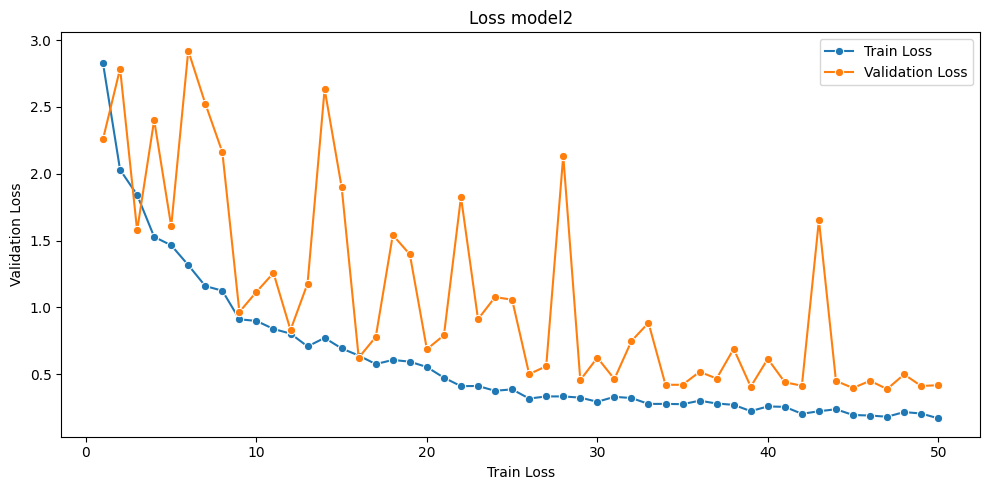

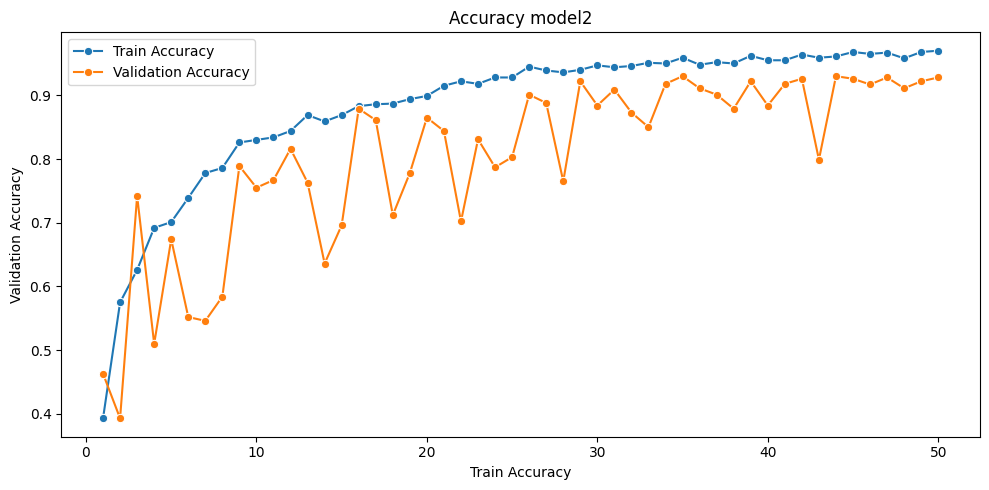

best model found at 0 loss is 3.87 accuracy is 0.435
best model found at 1 loss is 1.924 accuracy is 0.598
epoca 2 loss is 2.768 accuracy is 0.518
best model found at 3 loss is 1.258 accuracy is 0.753
epoca 4 loss is 1.38 accuracy is 0.713
epoca 5 loss is 1.444 accuracy is 0.729
epoca 6 loss is 2.842 accuracy is 0.605
epoca 7 loss is 2.579 accuracy is 0.626
best model found at 8 loss is 0.883 accuracy is 0.837
epoca 9 loss is 0.971 accuracy is 0.81
epoca 10 loss is 2.39 accuracy is 0.689
epoca 11 loss is 1.057 accuracy is 0.784
best model found at 12 loss is 0.957 accuracy is 0.841
epoca 13 loss is 0.96 accuracy is 0.825
epoca 14 loss is 0.891 accuracy is 0.827
epoca 15 loss is 1.578 accuracy is 0.759
epoca 16 loss is 1.261 accuracy is 0.78
best model found at 17 loss is 0.516 accuracy is 0.924
epoca 18 loss is 0.657 accuracy is 0.877
epoca 19 loss is 0.588 accuracy is 0.898
epoca 20 loss is 0.595 accuracy is 0.877
epoca 21 loss is 0.865 accuracy is 0.85
best model found at 22 loss is 

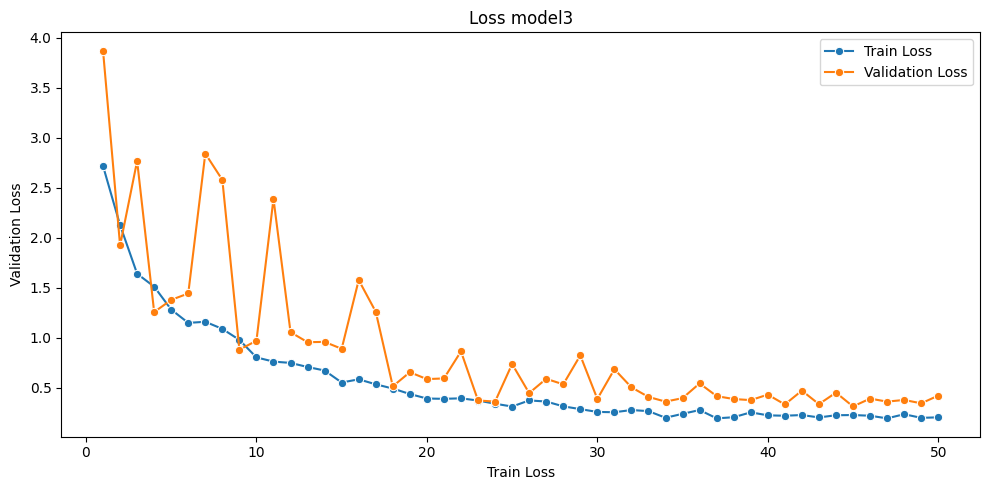

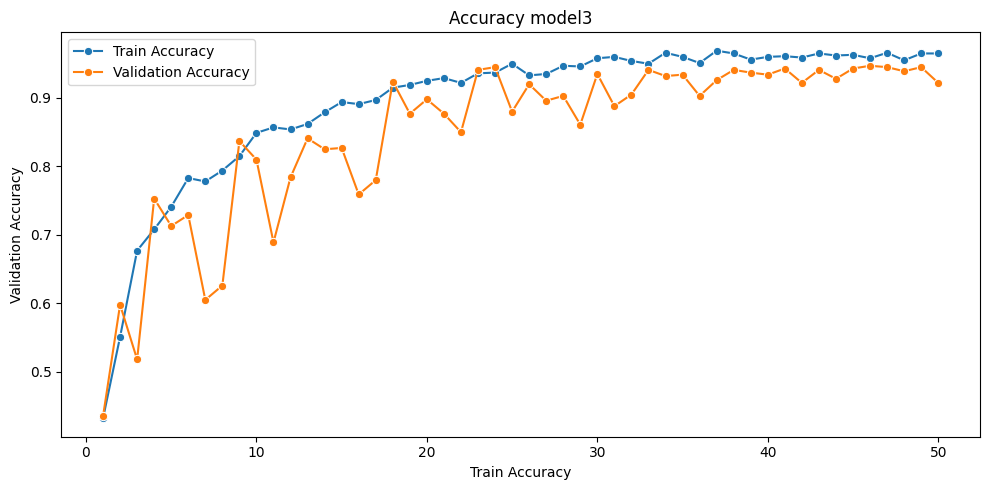

best model found at 0 loss is 3.128 accuracy is 0.309
best model found at 1 loss is 1.817 accuracy is 0.619
epoca 2 loss is 1.917 accuracy is 0.613
epoca 3 loss is 2.719 accuracy is 0.537
best model found at 4 loss is 1.803 accuracy is 0.639
best model found at 5 loss is 1.359 accuracy is 0.719
epoca 6 loss is 2.342 accuracy is 0.655
epoca 7 loss is 2.014 accuracy is 0.594
epoca 8 loss is 1.986 accuracy is 0.638
epoca 9 loss is 1.802 accuracy is 0.672
best model found at 10 loss is 1.021 accuracy is 0.806
epoca 11 loss is 1.05 accuracy is 0.795
best model found at 12 loss is 0.909 accuracy is 0.824
epoca 13 loss is 1.131 accuracy is 0.772
best model found at 14 loss is 0.668 accuracy is 0.879
epoca 15 loss is 1.029 accuracy is 0.799
epoca 16 loss is 1.114 accuracy is 0.772
epoca 17 loss is 0.925 accuracy is 0.82
best model found at 18 loss is 0.577 accuracy is 0.894
epoca 19 loss is 0.587 accuracy is 0.888
epoca 20 loss is 0.64 accuracy is 0.888
epoca 21 loss is 1.459 accuracy is 0.784

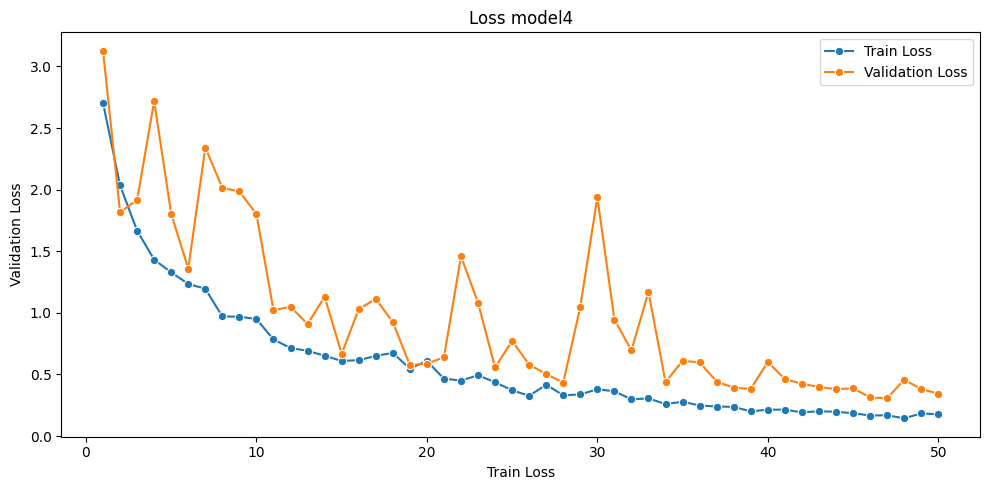

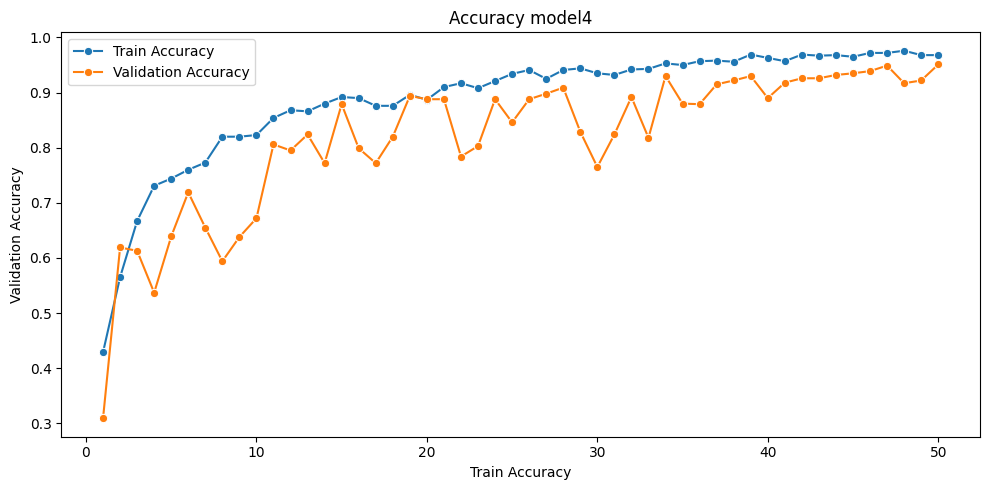

   precision    recall   f1Score  accuracy
0   0.664137  0.717166  0.654081  0.677665
1   0.734297  0.795895  0.728008  0.748731
2   0.712697  0.785941  0.695612  0.728426
3   0.723631  0.784958  0.713416  0.733503
4   0.715852  0.766402  0.706654  0.733503


In [92]:
K = 5
BALANCED = True
training_info, test_info = get_training_testing_data(BALANCED)
training_info, validation_info = split_traing_data(training_info, 0.2)
data_chunks = split_for_cross_validation(training_info, K)

grid_parameters = {
    "batch_size": [5, 10, 25, 50, 100],
    "epochs" : [50],
    "lr": [1e-1, 1e-2, 1e-3, 1e-4],
    "weight_decay": [1e-3, 1e-4],
    "optimizer_patience" : [3, 4, 5],
    "lr_factor": [0.1, 0.3, 0.5, 0.7],
    "width": [8, 16],
    "expansion" : [2, 3, 4],
    "early_stopping_patience" : [10],
}

def compute_functions(model : Net, parameters):
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters["lr"], weight_decay=parameters["weight_decay"])
    return torch.nn.CrossEntropyLoss(), optimizer, torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
                patience=parameters["optimizer_patience"], factor=parameters["lr_factor"])

def compute_cross_validation(parameters, train_transforms, test_transforms):
    info_test = {"precision": [], "recall": [], "f1Score" : [], "accuracy" : []}
    for i in range(K):
        model = Net(width=parameters["width"], expansion=parameters["expansion"])
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        criterion, optimizer, lr_scheduler = compute_functions(model, parameters)
        data = create_cross_validation_data(data_chunks, test_info, i, train_transforms, test_transforms, parameters["epochs"])
        early_stopping = EarlyStopping("./aici.pth", parameters['early_stopping_patience'])
        training_loss, validation_loss, training_accuracy, validation_accuracy = train_model(model, parameters["epochs"],
            data, criterion, optimizer, lr_scheduler, early_stopping)
        show_plot(training_loss, validation_loss, "Train Loss", "Validation Loss", f"Loss model{i}")
        show_plot(training_accuracy, validation_accuracy, "Train Accuracy", "Validation Accuracy", f"Accuracy model{i}")
        best_model = Net(width=parameters["width"], expansion=parameters["expansion"])
        early_stopping.load_model(best_model)
        precision, recall, f1, acc, mat = test_model(best_model, data["test"], criterion)
        info_test = add_info(info_test, precision, acc, recall, f1)
    test_results = pd.DataFrame.from_dict(info_test, "columns")
    print(test_results)

current_parameters = {
    "batch_size": 50,
    "epochs" : 50,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "optimizer_patience" : 3,
    "lr_factor": 0.6,
    "width": 16,
    "expansion" : 3,
    "early_stopping_patience" : 10,
}

compute_cross_validation(current_parameters, compute_train_transformations, compute_test_transformation)